# Loading, visualizing, and processing point cloud data with Python

There exist several methods to load, visualize and process point cloud data using Python. A very pythonic way of processing point clouds in Python is through laspy and subsequent numpy processing. This is decribed here.

## Laspy and numpy

import necessary libraries

In [1]:
# can also be installed using pip here
!python -m pip install laspy[laszip] numpy py4dgeo matplotlib scipy pyproj

In [2]:
import laspy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D
# Use inline backend for static images (works everywhere)
%matplotlib inline

Load a `.LAZ/.las` file using laspy. `.LAZ` files are specific formats, that compress the data, making it easier to handle large clouds than old-school formats like `.xyz`, which just stores a separate x, y, and z value for each point in a csv-file like structure. With the latter a function like `np.loadtxt()` or `pd.read_csv()` can be used to read the file in python. But be aware that with very large point clouds this format becomes very ineffecient. Laspy can read point cloud info, and chunk them for example, without fully writing them to memory. Most `.xyz` files don't store any metadata either, like e.g., coordinate systems.

In [3]:
# read a point cloud
laz_file = 'clips_drone/20230927_72220_72420_451650_451850.laz'
with laspy.open(laz_file) as f_laz:
        laz = f_laz.read()
        xyz = laz.xyz # read the xyz values from the point cloud
        # there is way more to get here like classification, rgb, info 
        rgb = np.vstack((laz.red, laz.green, laz.blue)).T

        # CRS 
        crs = laz.header.parse_crs()


In [8]:
# we can also only read a chunk (the first 10,000 points for example)
with laspy.open(laz_file) as f_laz:
        total_points = f_laz.header.point_count
        print(f"Total number of points in the file: {total_points}")

        # we read only the first 10_000 points
        n_points = 10_000
        chunk = f_laz.read_points(n_points)

        # read the xyz values and rgb values
        xyz = np.vstack((chunk.x, chunk.y, chunk.z)).T
        rgb = np.vstack((chunk.red, chunk.green, chunk.blue)).T

        # maybe you can even process one chunk, and then the other etc. to not overload the memory

Total number of points in the file: 21604316


In [ ]:
# or read text file (.xyz) using numpy
txt_file = '../20NZE009sl5_1.xyz' # also with ascii, then we can also save it to xyz, or even to LAZ (!)
xyz = np.loadtxt(txt_file)

### Visualize the point cloud in a 2d and 3d projection

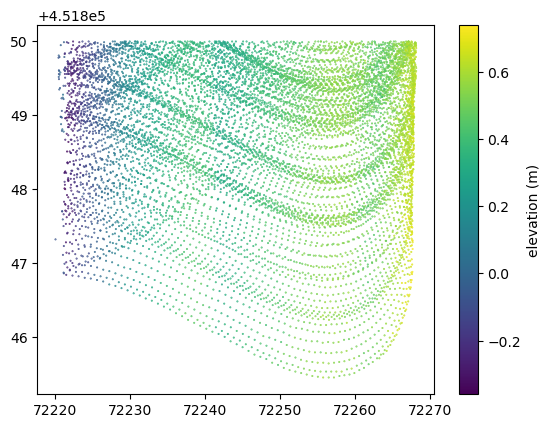

In [10]:
plt.figure()
plt.scatter(*xyz[:,:2].T, c=xyz[:,2], s=0.2)
plt.colorbar(label='elevation (m)')

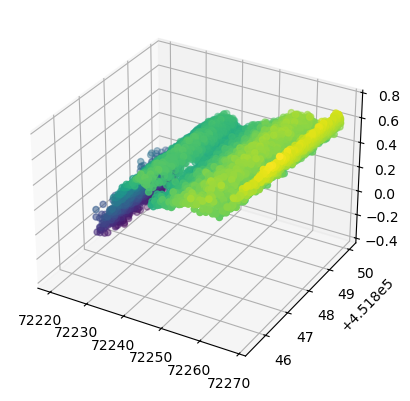

In [11]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

# visualize the point cloud with colored z-value
ax1.scatter(*xyz.T, c=xyz[:,2])


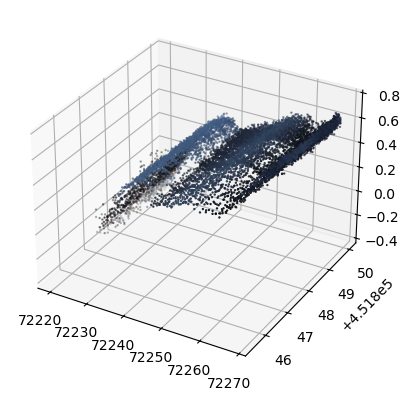

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# or with actual rgb values
# first scale the rgb values from 0 to 1, for matplotlib to understand
rgb_norm = (rgb - np.min(rgb, axis=0)) / (np.max(rgb,axis=0) - np.min(rgb,axis=0)) 
ax.scatter(*xyz.T, c=np.flip(rgb_norm, axis=1), s=0.5) # rgb values are flipped, not sure why

### transform the data using some transformation matrix
Some data may be in a different coordinate system than you want. A transformation matrix between the two systems can then transform your coordinates to your preferred coordinates

In [13]:
transform_matrix =np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0]]) # not transformed, but define anything, last column is translation, diagonal is rotation
xyz_transform = xyz @ transform_matrix

### interpolate/rasterize the data

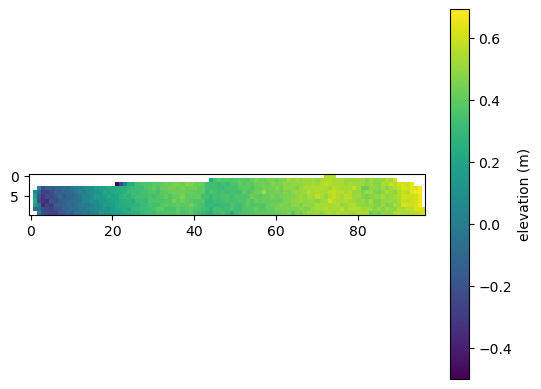

In [14]:
# f.e., build a grid, on which to interpolate
x_size, y_size = 0.5, 0.5 # cell size of grid

# create a grid with this cell size bounding your point cloud
grid_x, grid_y = np.meshgrid(
    np.arange(min(xyz[:,0]), max(xyz[:,0]), x_size), 
    np.arange(min(xyz[:,1]), max(xyz[:,1]), y_size)
)

# interpolate using scipy's grid interpolation method
grid_z = griddata((xyz[:,0], xyz[:,1]), xyz[:,2], (grid_x, grid_y), method='cubic')  

# visualize grid
plt.figure()
plt.imshow(grid_z)
plt.colorbar(label='elevation (m)')

Now you could compute two rasters from two different epochs and difference them, see what has happened!